# Étape 4 : Approche supervisée
- **Objectifs :**
    - Développer plusieurs modèles supervisés multi-label
    - Comparer différentes techniques d’embeddings
- **Sous-tâches :**
    1. Bag-of-Words avec modèle simple (Logistic Regression, RandomForest, etc.)
    2. Embeddings Word2Vec / Doc2Vec / GloVe
    3. BERT (ou distilBERT, pour faire plus léger) + fine-tuning éventuel
    4. USE (Universal Sentence Encoder)
    5. Comparaison des modèles avec des métriques adaptées (hamming loss, F1 macro/micro, coverage…)

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

: 

In [3]:
df = pd.read_csv('données_propre/dataset_final.csv')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4997 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       4997 non-null   object
 1   Body        4997 non-null   object
 2   Tags        4997 non-null   object
 3   text        4997 non-null   object
 4   text_clean  4997 non-null   object
dtypes: object(5)
memory usage: 234.2+ KB


## Encodage des features

In [6]:
# Les librairie de transformations de nos données
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [8]:
def BOW_embeddings(tf, ct, data):
    if tf:
        vectorizer = TfidfVectorizer()
    elif ct:
        vectorizer = CountVectorizer()
    else:
        raise ValueError("Spécifié si tf=True ou ct=True")
    X = vectorizer.fit_transform(data)
    print(f"Shape des features BOW: {X.shape}")
    return X

# Charger le modèle USE depuis TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def use_embeddings(text):
    # Extraire la colonne texte et générer les embeddings
    embeddings = use_model(text)  # Renvoie un tenseur
    print("Shape des embeddings USE :", (embeddings.numpy()).shape)
    return embeddings.numpy()  # Conversion en numpy array


# Chargement du modèle BERT (adapté pour les embeddings de phrases)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
def bert_embeddings(text):
    """
    Encode une liste de textes en vecteurs avec BERT.

    :param texts: Liste de phrases
    :return: Array NumPy shape (n_samples, 384)
    """
    embeddings = bert_model.encode(text, convert_to_numpy=True)
    print("Shape des embeddings BERT :", (embeddings).shape)
    return embeddings

In [10]:
X_bow = BOW_embeddings(tf=True, ct=False, data=df['text_clean'])

Shape des features BOW: (4997, 32543)


In [12]:
X_use = use_embeddings(df['text_clean'].tolist())

Shape des embeddings USE : (4997, 512)


In [14]:
X_bert = bert_embeddings(df['text_clean'].tolist())

Shape des embeddings BERT : (4997, 384)


In [16]:
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=404)


# Encodage de nos données
mlb = MultiLabelBinarizer()
mlb.fit(df['Tags'])

def encode_label(y_train, y_test):
    # Appliquons le sur nos données
    y_train_en = mlb.transform(y_train)
    y_test_en = mlb.transform(y_test)
    # supprissons des labels (UserWarning: Label 2,15,16 is present in all training examples)
    labels_to_remove = [2, 15, 16]
    # Suppression des labels omniprésents
    y_train_en = np.delete(y_train_en, labels_to_remove, axis=1)
    y_test_en = np.delete(y_test_en, labels_to_remove, axis=1)
    return y_train_en, y_test_en

In [18]:
# bag of words
X_bow_train, X_bow_test, y_train, y_test = split_data(X_bow, df['Tags'])
y_bow_train, y_bow_test = encode_label(y_train, y_test)
# use
X_use_train, X_use_test, y_train, y_test = split_data(X_use, df['Tags'])
y_use_train, y_use_test = encode_label(y_train, y_test)
# bert
X_bert_train, X_bert_test, y_train, y_test = split_data(X_bert, df['Tags'])
y_bert_train, y_bert_test = encode_label(y_train, y_test)

## Modelisation
Logistic Regression (One-vs-Rest - OvR)
Random Forest Classifier
(SVC) One-vs-Rest - OvR
MLP (Multi-Layer Perceptron - Réseau Neuronal Simple)
BERT Fine-Tuning pour Multi-Label Classification

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import LearningCurveDisplay

from sklearn.metrics import f1_score, hamming_loss, accuracy_score, jaccard_score

In [23]:
# Évalue la performance d'un modèle de classification multi-label
def evaluate_model( model, X_train, y_train, y_true, y_pred): 
    """
    Paramètres :
    - model : model utilisée
    - X_train : données d'entrainement (embeding)
    - y_train : Labels d'entrainement (multi-hot encoding)
    - y_true : Labels réels (multi-hot encoding)
    - y_pred : Labels prédits (multi-hot encoding)
    
    Retourne :
    - Un dictionnaire avec les scores des différentes métriques.
    """
    scores = {
        "Micro F1-score": f1_score(y_true, y_pred, average="micro"),
        "Macro F1-score": f1_score(y_true, y_pred, average="macro"),
        "Hamming Loss": hamming_loss(y_true, y_pred),
        "Exact Match Ratio": accuracy_score(y_true, y_pred),
        "Jaccard Similarity": jaccard_score(y_true, y_pred, average="samples")
    }
    
    LearningCurveDisplay.from_estimator(model, X_train, y_train, cv=4, scoring='f1_micro')
    
    return scores

### BAG OF WORDS
tf-idf vectorizer:
- Evaluation du model SVC avec BOW {'Micro F1-score': 0.6728990164572987, 'Macro F1-score': 0.42457153344515974, 'Hamming Loss': 0.16795, 'Exact Match Ratio': 0.011, 'Jaccard Similarity': 0.5000929713557557}
- Evaluation du model RandomForest avec BOW {'Micro F1-score': 0.6007351480230478, 'Macro F1-score': 0.2334923913488546, 'Hamming Loss': 0.20095, 'Exact Match Ratio': 0.0, 'Jaccard Similarity': 0.41875896781666905}
- Evaluation du model LogisticRegression avec BOW {'Micro F1-score': 0.6707717569786535, 'Macro F1-score': 0.5418316816842665, 'Hamming Loss': 0.18045, 'Exact Match Ratio': 0.013, 'Jaccard Similarity': 0.4965621802973677}
- Optez pour le TF-IDF comme vectoriseur, avec LogisticRegression comme modèle.

In [26]:
model_lgt = OneVsRestClassifier(LogisticRegression(class_weight='balanced'))
model_rdf = RandomForestClassifier(class_weight='balanced')
model_svc = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced'))
# pas d'oublie sur le lstm
# Entrainement de nos model sur bag of words
model_lgt.fit(X_bow_train,y_bow_train)
#model_rdf.fit(X_bow_train,y_bow_train)
#model_svc.fit(X_bow_train,y_bow_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))

In [ ]:
# Prédiction sur les données de test
y_pred = model_lgt.predict(X_bow_test)
print('Evaluation du model LogisticRegression avec BOW', evaluate_model(model_lgt,X_bow_train, y_bow_train, y_bow_test, y_pred))
#y_pred = model_rdf.predict(X_bow_test)
#print('Evaluation du model RandomForest avec BOW', evaluate_model(model_rdf,X_bow_train, y_bow_train, y_bow_test, y_pred))
#y_pred = model_svc.predict(X_bow_test)
#print('Evaluation du model SVM avec BOW', evaluate_model(model_svc,X_bow_train, y_bow_train, y_bow_test, y_pred))

C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 11 is present in all training examples.
  warnings.warn(


### EMBEDING USE
- Evaluation du model LogisticRegression avec USE {'Micro F1-score': 0.6123719786972552, 'Macro F1-score': 0.4943583100518598, 'Hamming Loss': 0.23655, 'Exact Match Ratio': 0.001, 'Jaccard Similarity': 0.4320045916748084}
- Evaluation du model RandomForest avec USE {'Micro F1-score': 0.6038884524744698, 'Macro F1-score': 0.2416977123971329, 'Hamming Loss': 0.2017, 'Exact Match Ratio': 0.0, 'Jaccard Similarity': 0.42150406131816315}
- Evaluation du model SVM avec USE {'Micro F1-score': 0.662523642258849, 'Macro F1-score': 0.5024364986679525, 'Hamming Loss': 0.18735, 'Exact Match Ratio': 0.014, 'Jaccard Similarity': 0.48710655643189466}

In [86]:
# Entrainement sur nos model nos embedding use
#model_lgt.fit(X_use_train,y_use_train)
#model_rdf.fit(X_use_train,y_use_train)
#model_svc.fit(X_use_train,y_use_train)

OneVsRestClassifier(estimator=SVC(class_weight='balanced'))

In [88]:
# Prédiction sur les données de test
#y_pred = model_lgt.predict(X_use_test)
#print('Evaluation du model LogisticRegression avec USE', evaluate_model(y_use_test, y_pred))
#y_pred = model_rdf.predict(X_use_test)
#print('Evaluation du model RandomForest avec USE', evaluate_model(y_use_test, y_pred))
#y_pred = model_svc.predict(X_use_test)
#print('Evaluation du model SVM avec USE', evaluate_model(y_use_test, y_pred))

Evaluation du model SVM avec USE {'Micro F1-score': 0.662523642258849, 'Macro F1-score': 0.5024364986679525, 'Hamming Loss': 0.18735, 'Exact Match Ratio': 0.014, 'Jaccard Similarity': 0.48710655643189466}


### EMBEDING BERT
- Evaluation du model LogisticRegression avec BERT {'Micro F1-score': 0.6389502187044366, 'Macro F1-score': 0.5223305453331785, 'Hamming Loss': 0.216675, 'Exact Match Ratio': 0.005, 'Jaccard Similarity': 0.4591644560435377}
- Evaluation du model RandomForest avec BERT {'Micro F1-score': 0.5975009838646202, 'Macro F1-score': 0.21966569807861597, 'Hamming Loss': 0.20455, 'Exact Match Ratio': 0.0, 'Jaccard Similarity': 0.4145141889285465}
- Evaluation du model SVM avec BERT {'Micro F1-score': 0.6994788125991389, 'Macro F1-score': 0.5430263568170026, 'Hamming Loss': 0.165775, 'Exact Match Ratio': 0.022, 'Jaccard Similarity': 0.5301808863886297}

In [46]:
# Entrainement sur nos model nos embedding use
#model_lgt.fit(X_bert_train,y_bert_train)
#model_rdf.fit(X_bert_train,y_bert_train)
model_svc.fit(X_bert_train,y_bert_train)

OneVsRestClassifier(estimator=SVC(class_weight='balanced'))

C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 11 is present in all training examples.
  warnings.warn(


Evaluation du model SVM avec BERT {'Micro F1-score': 0.6994788125991389, 'Macro F1-score': 0.5430263568170026, 'Hamming Loss': 0.165775, 'Exact Match Ratio': 0.022, 'Jaccard Similarity': 0.5301808863886297}


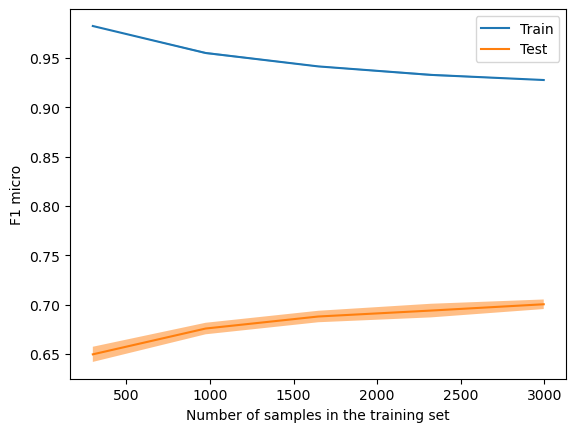

In [48]:
# Prédiction sur les données de test
#y_pred = model_lgt.predict(X_bert_test)
#print('Evaluation du model LogisticRegression avec BERT', evaluate_model(y_bert_test, y_pred))
#y_pred = model_rdf.predict(X_bert_test)
#print('Evaluation du model RandomForest avec BERT', evaluate_model(y_bert_test, y_pred))
y_pred = model_svc.predict(X_bert_test)
print('Evaluation du model SVM avec BERT', evaluate_model(model_svc,X_bert_train, y_bert_train, y_bert_test, y_pred))

### CHOIX DES 2 MEILLEUR MODELS + OPTIMISATION DES HYPERPARAMETRES
- le couple TF‑IDF + LogisticRegression obtenir des scores légèrement supérieurs (notamment au niveau du Micro F1-score et du Jaccard Similarity)
- le couple BERT + SVM est à aussi privilégier.
- faire un RandomizeSearchCV (comme plus rapide) et puis restreindre la zone trouvé avec un GridSearchCV

In [54]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform  # Permet d'explorer des plages sur une échelle logarithmique

In [ ]:
#### Tuning des hyperparamètres du model LogistiqueRegresion

In [ ]:
# Définir la distribution des hyperparamètres à tester
param = {
    "estimator__C": loguniform(1e-3, 1e3),         # Exploration de C entre 0.001 et 1000
    "estimator__penalty": ['l1', 'l2']              # Tester les deux pénalités possibles
}

# Mise en place du RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_lgt,
    param_distributions=param,
    n_iter=20,              # Nombre d'itérations (combinations testées)
    scoring='f1_micro', 
    cv=5,                   # Validation croisée à 5 plis
    random_state=404
)

# Lancer la recherche sur vos données d'entraînement
random_search.fit(X_bow_train, y_bow_train)
y_pred = (random_search.best_estimator).predict(X_bert_test)
print("Meilleurs paramètres trouvés (LogisticRegression) :", random_search_lr.best_params_)
print('Evaluation du model LogisticRegression avec BOW', evaluate_model(random_search.best_estimator,X_bow_train, y_bow_train, y_bow_test, y_pred))

In [ ]:
# Récupérer les meilleurs paramètres trouvés
best_C = random_search_lr.best_params_["estimator__C"]
best_penalty = random_search_lr.best_params_["estimator__penalty"]

# Définir une grille autour de la meilleure valeur de C (en divisant et multipliant par 10)
param_grid = {
    "estimator__C": [best_C / 10, best_C, best_C * 10],
    "estimator__penalty": [best_penalty]
}

# Affiner la recherche avec GridSearchCV
grid_search_lr = GridSearchCV(
    model_lgt,
    param_grid=param_grid,
    scoring='f1_micro',
    cv=5
)
grid_search_lr.fit(X_bow_train, y_bow_train)
print("Meilleurs paramètres affinés (LogisticRegression) :", grid_search.best_params_)
y_pred = (random_search.best_estimator).predict(X_bert_test)
print('Evaluation du model LogisticRegression avec BOW', evaluate_model(random_search.best_estimator,X_bow_train, y_bow_train, y_bow_test, y_pred))